### Remote work impacts on health

#### Description 
The Post-Pandemic Remote Work Health Impact 2025 dataset presents a comprehensive, global snapshot of how remote, hybrid, and onsite work arrangements are influencing the mental and physical health of employees in the post-pandemic era. Collected in June 2025, this dataset aggregates responses from a diverse workforce spanning continents, industries, age groups, and job roles. It is designed to support research, data analysis, and policy-making around the evolving landscape of work and well-being.

This dataset enables in-depth exploration of:

The prevalence of mental health conditions (e.g., anxiety, burnout, PTSD, depression) across different work setups.
The relationship between work arrangements and physical health complaints (e.g., back pain, eye strain, neck pain).
Variations in work-life balance, social isolation, and burnout levels segmented by demographic and occupational factors.
Salary distributions and their correlation with health outcomes and job roles.
By providing granular, anonymized data on both subjective (self-reported) and objective (hours worked, salary range) factors, this resource empowers data scientists, health researchers, HR professionals, and business leaders to:

Identify risk factors and protective factors for employee well-being.
Benchmark health impacts across industries and regions.
Inform organizational policy and future-of-work strategies.

In [48]:
import pandas as pd
import numpy as np 
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder

# dt imports 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
from sklearn import tree


pd.set_option("display.max_columns", None)

api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    'kshitijsaini121/remote-work-of-health-impact-survey-june-2025',
    path='data/',
    unzip=True 
)

df = pd.read_csv("data/post_pandemic_remote_work_health_impact_2025.csv", parse_dates=['Survey_Date'])

df.head()

Dataset URL: https://www.kaggle.com/datasets/kshitijsaini121/remote-work-of-health-impact-survey-june-2025


,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


## Data Cleaning 

Missing Values and Outlier Detection 

In [2]:
isna_cols = df.isna().sum()

print(isna_cols)

Survey_Date                  0
Age                          0
Gender                       0
Region                       0
Industry                     0
Job_Role                     0
Work_Arrangement             0
Hours_Per_Week               0
Mental_Health_Status       799
Burnout_Level                0
Work_Life_Balance_Score      0
Physical_Health_Issues     280
Social_Isolation_Score       0
Salary_Range                 0
dtype: int64


In [3]:
print(df['Mental_Health_Status'].value_counts())

Mental_Health_Status
PTSD               423
Anxiety            394
Burnout            392
Depression         386
ADHD               385
Stress Disorder    378
Name: count, dtype: int64


In [4]:
# Replace missing values in this column with 'None' because that was what was indicated in the documentation
df['Mental_Health_Status'] = df['Mental_Health_Status'].fillna('None')

In [5]:
print(df['Mental_Health_Status'].value_counts())

Mental_Health_Status
None               799
PTSD               423
Anxiety            394
Burnout            392
Depression         386
ADHD               385
Stress Disorder    378
Name: count, dtype: int64


## Data Engineering (Prep for models) 

In [6]:
# change Burnout Level from 1 to 3
df['Burnout_Level'].value_counts()

df['Burnout_Level'] = df['Burnout_Level'].replace({
    'Low': 1,
    'Medium' : 2,
    'High': 3
})

/var/folders/tm/zd2ldwcj6w5cml9j9n1_pcsr0000gn/T/ipykernel_37992/3335120009.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Burnout_Level'] = df['Burnout_Level'].replace({


In [7]:
# one-hot encode the mutli-valued columns 
lists = (
    df['Physical_Health_Issues']
      .fillna('')
      .str.split(';')
      .apply(lambda L: [item.strip() for item in L if item.strip()])
)

mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(lists)

prefix = "Physical_Health_"
cols   = [f"{prefix}{cat}" for cat in mlb.classes_]

onehot_physical_health = pd.DataFrame(
    onehot,
    columns=cols,
    index=df.index
)

df.drop("Physical_Health_Issues", axis = 1, inplace = True)

df_onehot = pd.concat([df, onehot_physical_health], axis = 1)


In [8]:
def return_likert_to_binary(df, col):
    ind_col = f"{col}_ind"
    print(f"Converting column {col} to binary → {ind_col}")
    df[ind_col] = np.where(df[col] >= 4, 1, 0)
    return df

df_onehot = return_likert_to_binary(df_onehot, "Work_Life_Balance_Score")
df_onehot = return_likert_to_binary(df_onehot, "Social_Isolation_Score")

Converting column Work_Life_Balance_Score to binary → Work_Life_Balance_Score_ind
Converting column Social_Isolation_Score to binary → Social_Isolation_Score_ind


In [10]:
cat_vars = df.select_dtypes(include = ['object', 'category']).columns.to_list()

print(f"List of Categorical Variables to be one-hot encoded: {cat_vars}")

# def fn to one-hot for decision tree 
def one_hot_encode(df, cols): 
    return pd.get_dummies(
        df, 
        columns=cols, 
        prefix=cols, 
        dtype = int
    )

df_encoded = one_hot_encode(df, cat_vars)

List of Categorical Variables to be one-hot encoded: ['Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Mental_Health_Status', 'Salary_Range']


In [16]:
def plot_histogram(df, cols, bins = 10, figsize = (8,4)): 
    for col in cols: 
        plt.figure(figsize=figsize)

        df[col].dropna().hist(bins = bins)

        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()

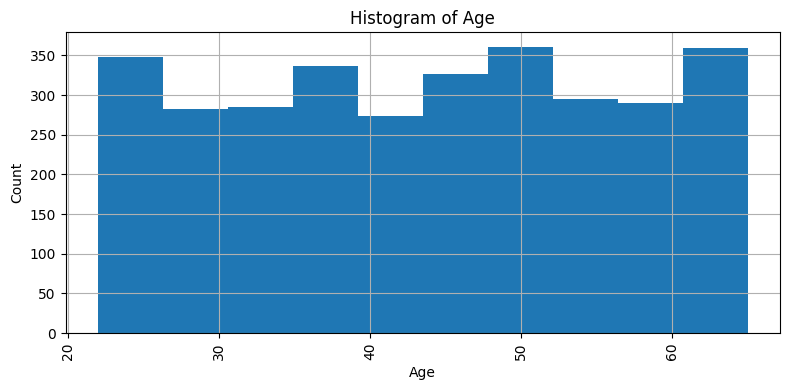

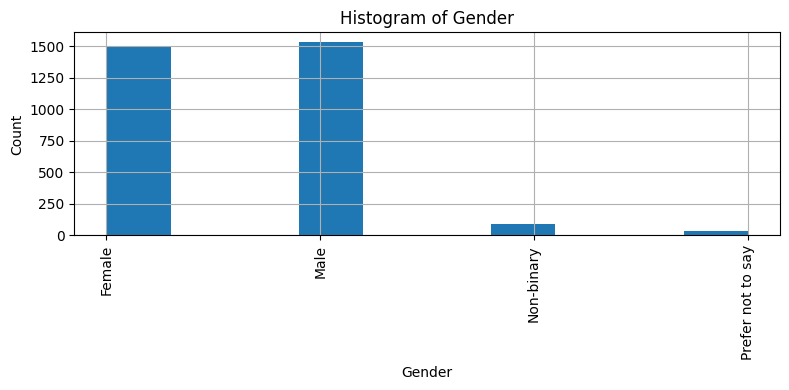

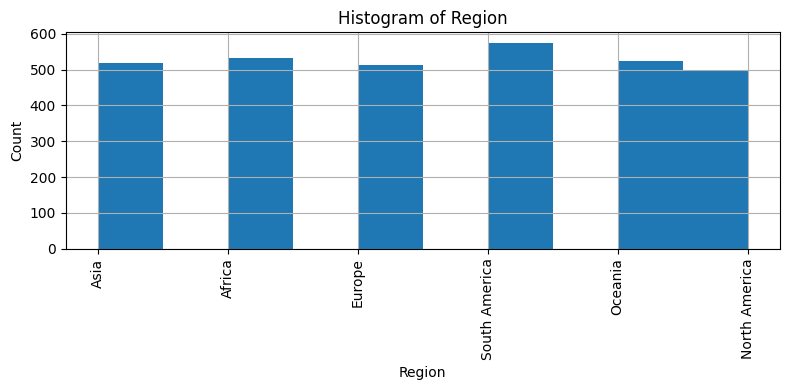

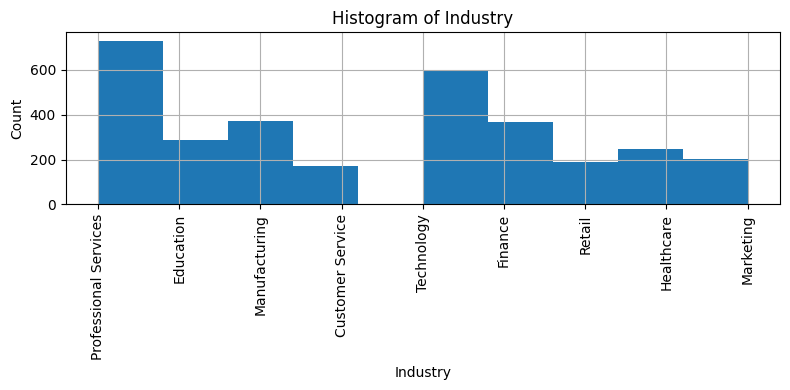

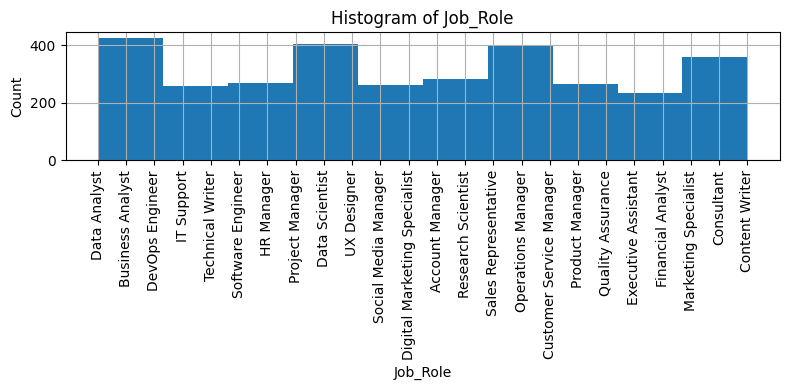

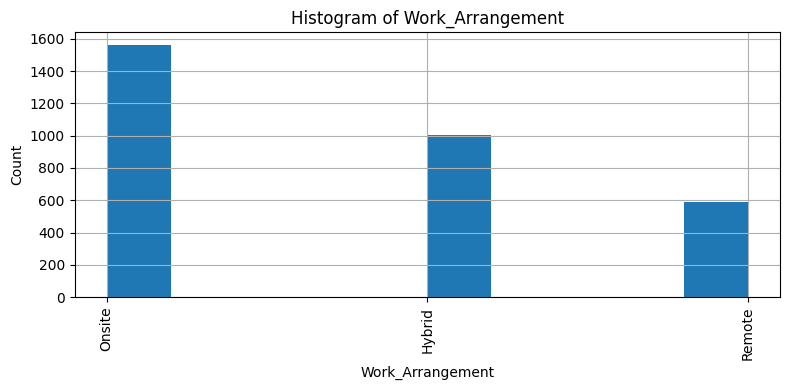

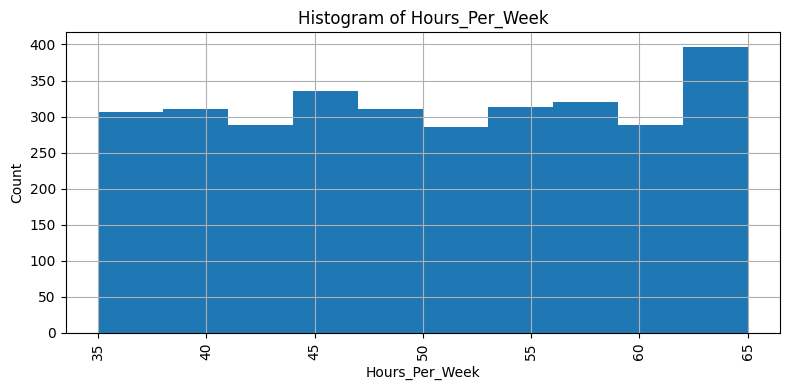

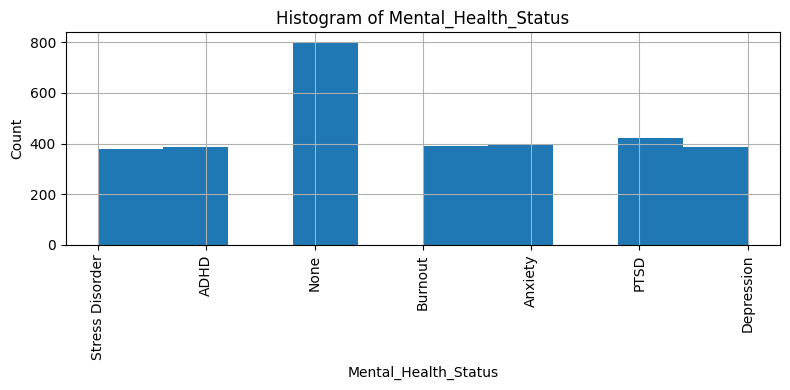

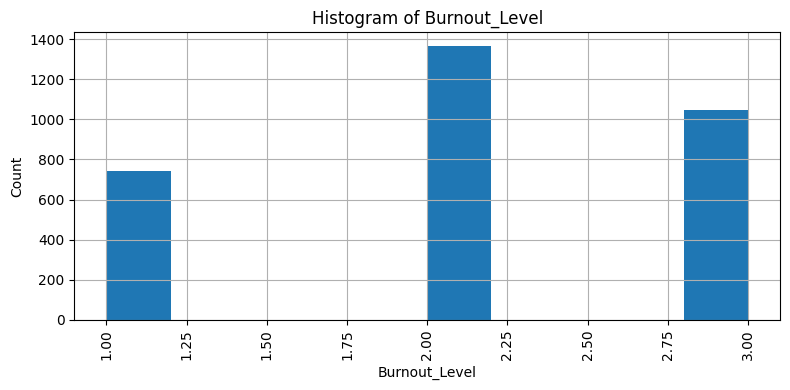

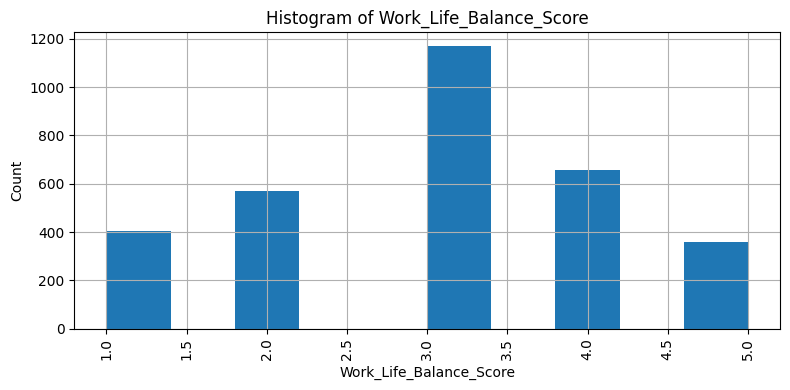

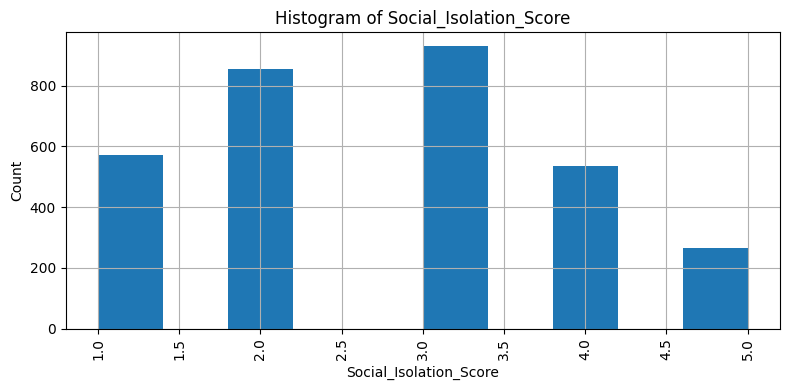

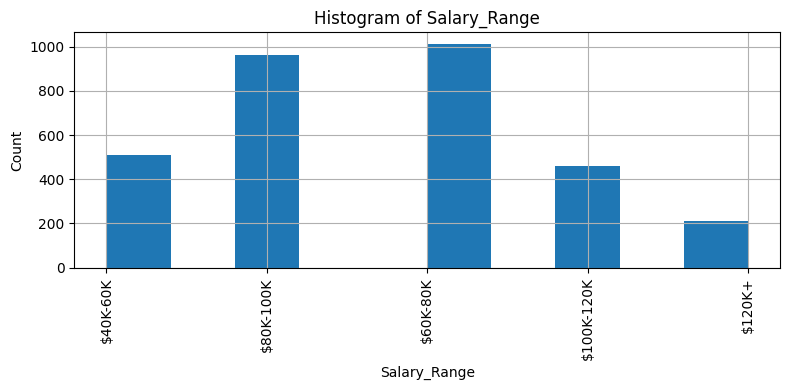

In [17]:
plot_histogram(df, ['Age', 'Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Hours_Per_Week', 'Mental_Health_Status', 'Burnout_Level', 'Work_Life_Balance_Score', 
                    'Social_Isolation_Score', 'Salary_Range'])

## Model Development

---- 

#### Decision Tree

In [36]:
X

,Age,Hours_Per_Week,Burnout_Level,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Africa,Region_Asia,Region_Europe,Region_North America,Region_Oceania,Region_South America,Industry_Customer Service,Industry_Education,Industry_Finance,Industry_Healthcare,Industry_Manufacturing,Industry_Marketing,Industry_Professional Services,Industry_Retail,Industry_Technology,Job_Role_Account Manager,Job_Role_Business Analyst,Job_Role_Consultant,Job_Role_Content Writer,Job_Role_Customer Service Manager,Job_Role_Data Analyst,Job_Role_Data Scientist,Job_Role_DevOps Engineer,Job_Role_Digital Marketing Specialist,Job_Role_Executive Assistant,Job_Role_Financial Analyst,Job_Role_HR Manager,Job_Role_IT Support,Job_Role_Marketing Specialist,Job_Role_Operations Manager,Job_Role_Product Manager,Job_Role_Project Manager,Job_Role_Quality Assurance,Job_Role_Research Scientist,Job_Role_Sales Representative,Job_Role_Social Media Manager,Job_Role_Software Engineer,Job_Role_Technical Writer,Job_Role_UX Designer,Work_Arrangement_Hybrid,Work_Arrangement_Onsite,Work_Arrangement_Remote,Mental_Health_Status_ADHD,Mental_Health_Status_Anxiety,Mental_Health_Status_Burnout,Mental_Health_Status_Depression,Mental_Health_Status_None,Mental_Health_Status_PTSD,Mental_Health_Status_Stress Disorder,Salary_Range_$100K-120K,Salary_Range_$120K+,Salary_Range_$40K-60K,Salary_Range_$60K-80K,Salary_Range_$80K-100K
0,27,64,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,37,37,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,32,36,3,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,40,63,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,30,65,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,62,38,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3153,24,54,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3154,45,59,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3155,38,52,2,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [45]:
# Initalize New Dataframe for Decision Tree
X = df_encoded.drop(columns = [
    'Survey_Date',
    'Work_Life_Balance_Score',
    'Social_Isolation_Score'
])

y1 = df['Work_Life_Balance_Score']
y2 = df['Social_Isolation_Score']

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size= 0.3, random_state = 123)
_      , _    , y2_train, y2_test = train_test_split(X, y2, test_size = 0.3, random_state = 123)

X_train.items()

def shape_prnt(**vars):
    """
    Print the .shape of each variable passed as a keyword argument.
    Usage:
      shape_prnt(X_train=X_train, X_test=X_test, y1_train=y1_train)
    """
    for name, arr in vars.items():
        if hasattr(arr, 'shape'):
            print(f"Shape of {name}: {arr.shape}")
        else:
            print(f"{name!r} has no .shape attribute")

shape_prnt(
    X_train=X_train,
    X_test=X_test,
    y1_train=y1_train,
    y1_test=y1_test,
    y2_train=y2_train,
    y2_test=y2_test
)


Shape of X_train: (2209, 61)
Shape of X_test: (948, 61)
Shape of y1_train: (2209,)
Shape of y1_test: (948,)
Shape of y2_train: (2209,)
Shape of y2_test: (948,)


### Start Model Development

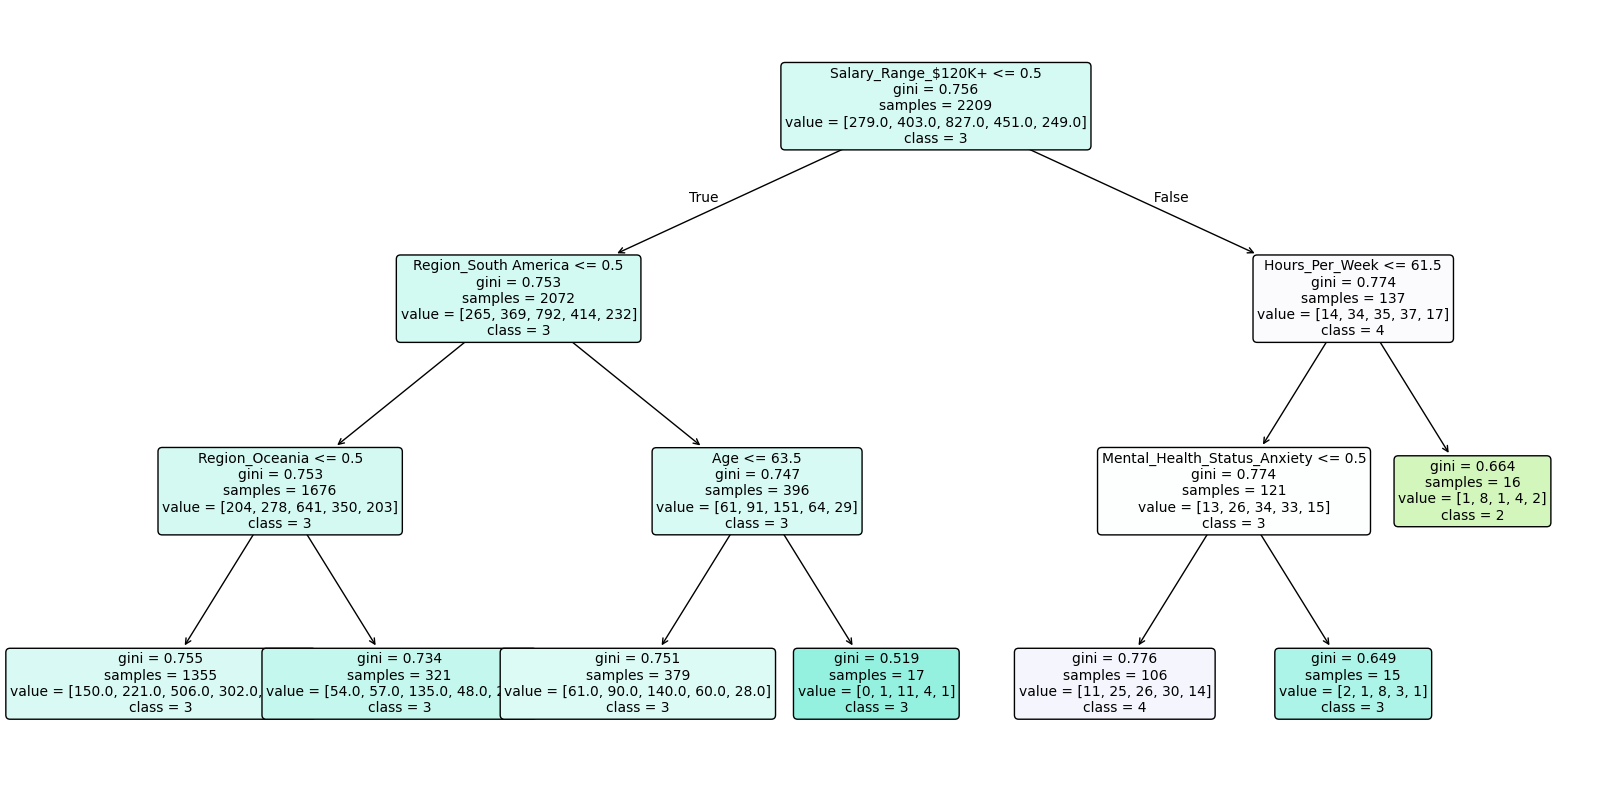

In [53]:
clf_wlb = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

clf_wlb.fit(X_train, y1_train)

plt.figure(figsize=(20,10))

tree.plot_tree(
    clf_wlb, 
    filled = True, 
    rounded = True, 
    feature_names= X.columns,
    class_names = [str(c) for c in clf_wlb.classes_], 
    fontsize=10
)

plt.show()

=== Training classification report ===
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       279
           2       0.50      0.02      0.04       403
           3       0.38      0.97      0.55       827
           4       0.28      0.07      0.11       451
           5       0.00      0.00      0.00       249

    accuracy                           0.38      2209
   macro avg       0.23      0.21      0.14      2209
weighted avg       0.29      0.38      0.23      2209

=== Training confusion Matrix ===


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


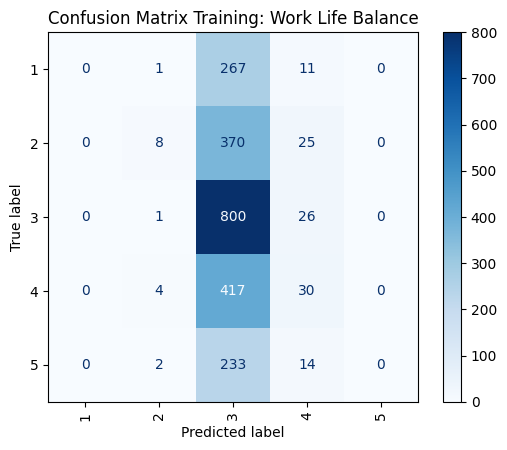

In [54]:
# Training Stats 
train_preds_wlb = clf_wlb.predict(X_train)

print("=== Training classification report ===")
print(classification_report(y1_train, train_preds_wlb))

print("=== Training confusion Matrix ===")
train_cm_wlb = confusion_matrix(y1_train, train_preds_wlb, labels = [1,2,3,4,5])
train_wlb_cm_display = ConfusionMatrixDisplay(
    train_cm_wlb, 
    display_labels=[1,2,3,4,5]
)

train_wlb_cm_display.plot(cmap = 'Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix Training: Work Life Balance')
plt.show()

classification report for work life balance 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       125
           2       0.29      0.01      0.02       169
           3       0.35      0.92      0.51       342
           4       0.15      0.04      0.06       204
           5       0.00      0.00      0.00       108

    accuracy                           0.34       948
   macro avg       0.16      0.19      0.12       948
weighted avg       0.21      0.34      0.20       948



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


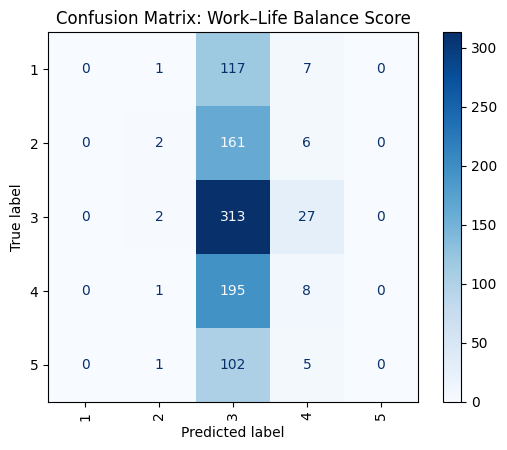

In [55]:
# Test Stats
preds_wlb = clf_wlb.predict(X_test)

print(f"classification report for work life balance \n {classification_report(y1_test, preds_wlb)}")

cm = confusion_matrix(y1_test, preds_wlb, labels=[1,2,3,4,5])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,2,3,4,5])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix: Work–Life Balance Score')
plt.show()